# Neural Networks Learning

*Not using the conventions in the asignment.
Building a neural network using the code from Andrew Ngs deep learning specialization

In [1]:
import numpy as np
import scipy.io as sio
from scipy import optimize
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data = sio.loadmat('data/neural_networks_learning.mat')
x=data['X']
y=data['y']
print(x.shape)
print(y.shape)

(5000, 400)
(5000, 1)


In [3]:
yprime = np.zeros(y.shape,dtype='int32')
for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        if y[i][j]==10:
            yprime[i][j]=0
        else:
            yprime[i][j]=y[i][j]
            
Y = tf.one_hot(yprime.T[0],10,dtype='int32').numpy().T
print(Y.shape)

X = x.T
print(X.shape)

(10, 5000)
(400, 5000)


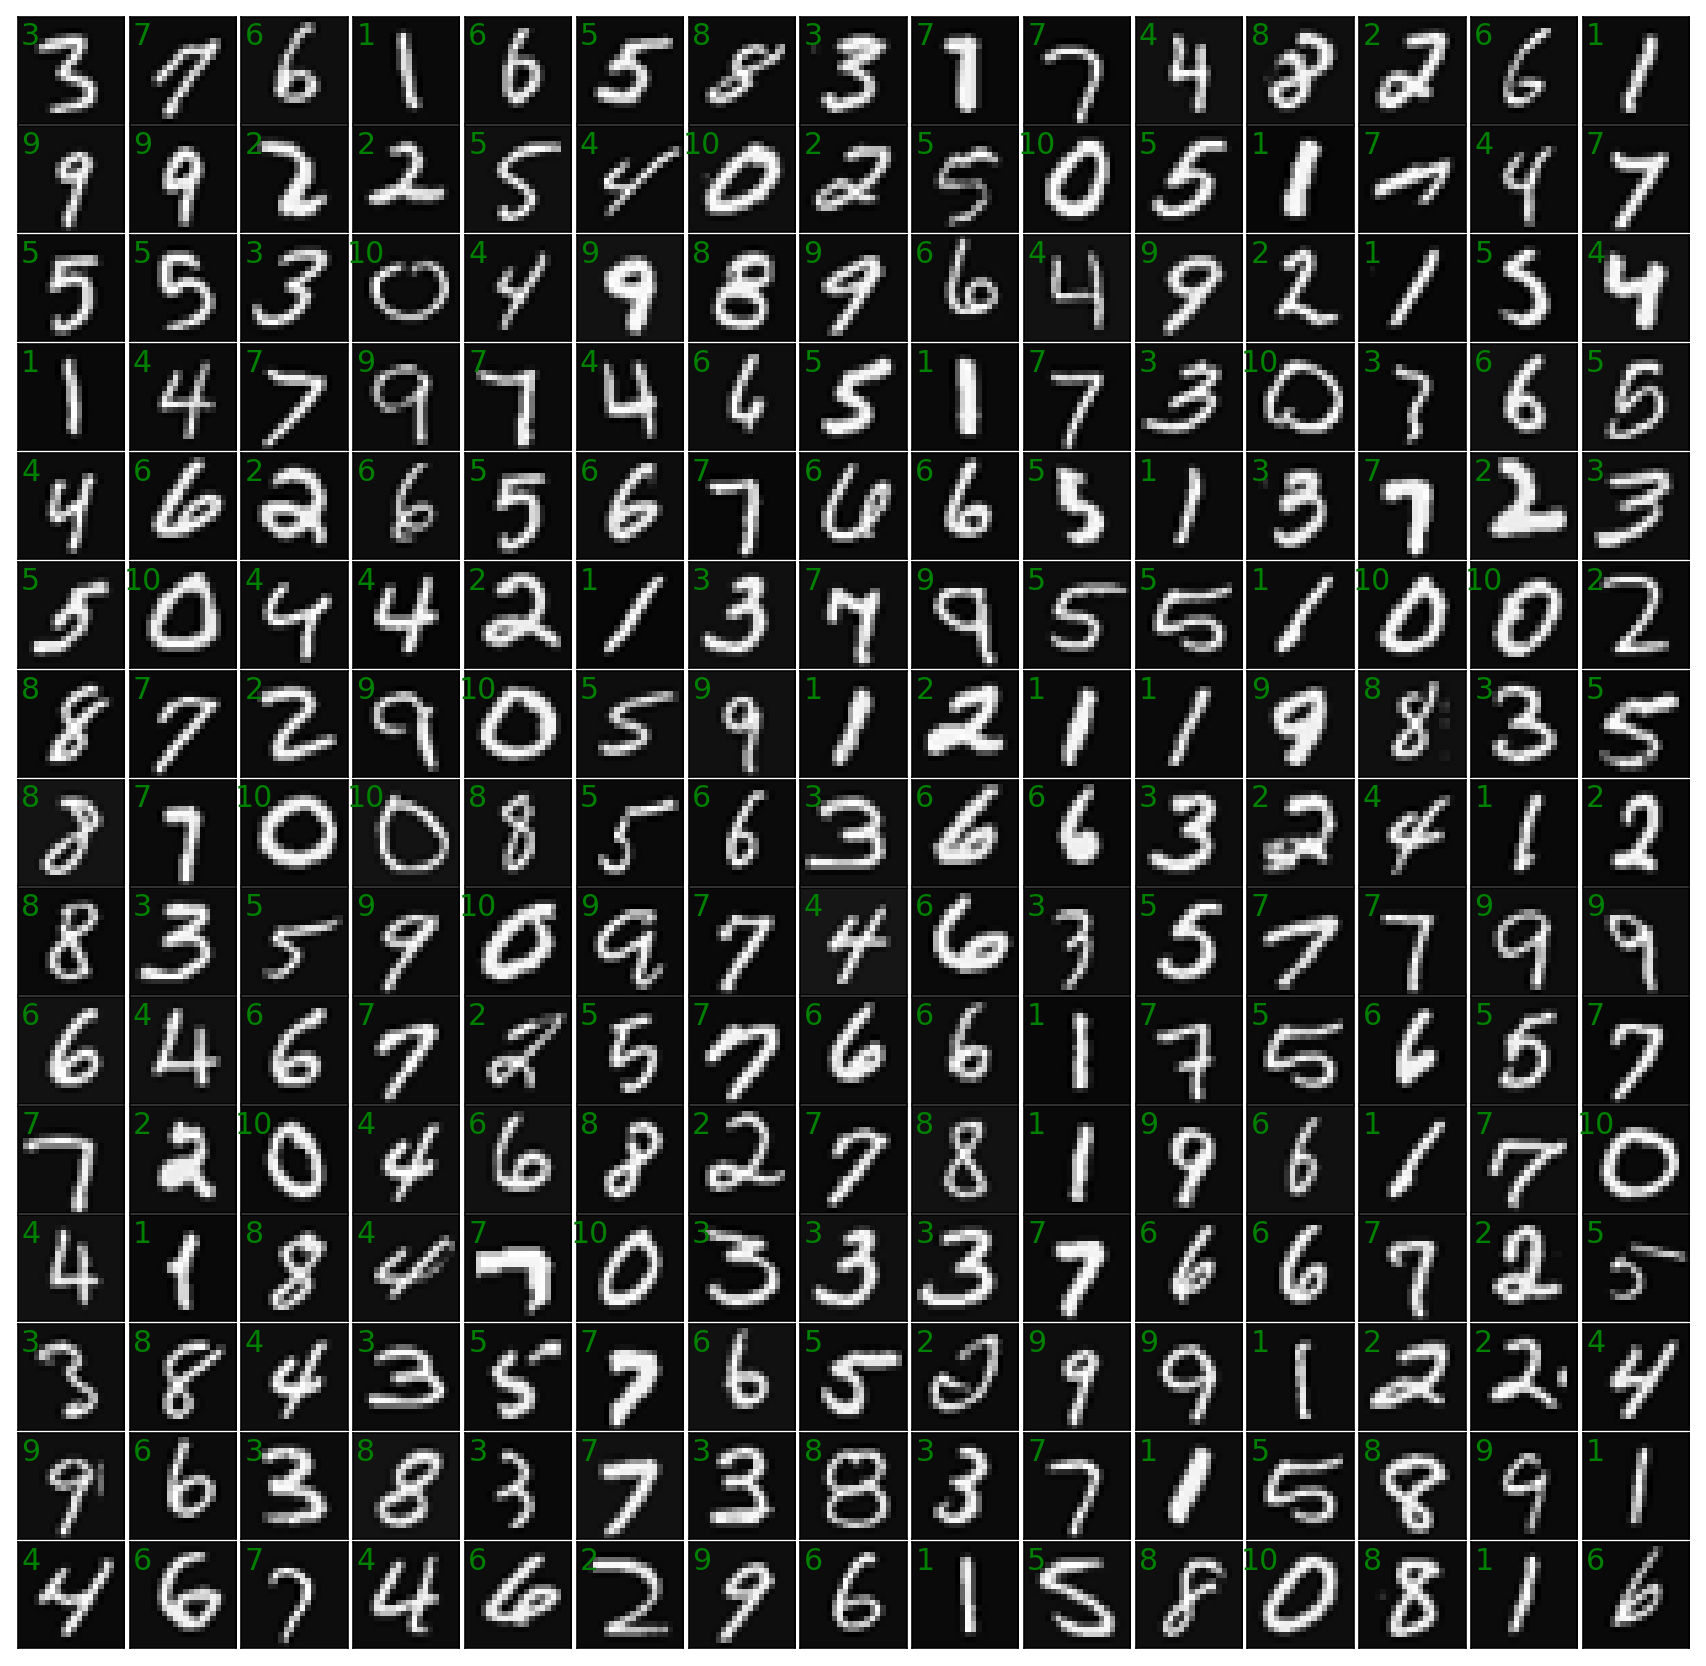

In [4]:
def visualize(x,y_pred,y):
    fig, axes = plt.subplots(nrows=15,ncols=15,figsize=(15,15))
    plt.subplots_adjust(wspace=0.025,hspace=0.025)
    for ax in axes.flatten():
        i=np.random.randint(x.shape[0])
        img = np.reshape(x[i],(20,20))
        img = img.T
        ax.imshow(img,cmap='gray')
        if y_pred[i] == y[i]:
            ax.set_title('{}'.format(y_pred[i][0]), color='g', fontsize=15, x=0.12,y=0.63)
        else:
            ax.set_title('{},{}'.format(y_pred[i][0],y[i][0]), color='r', fontsize=15, x=0.2,y=0.63)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
visualize(x,y,y)

In [5]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))  
    return parameters

In [6]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache

In [7]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A)+b
    
    cache = (A, W, b)
    
    return Z, cache

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [9]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
            
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))/m
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [11]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    L = len(parameters) // 2
    
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    
    L2_regularization_cost = 0
    for l in range(0, L):
        L2_regularization_cost += np.sum(np.square(parameters['W'+str(l+1)]))*lambd/(2*m)

    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [12]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
def linear_backward_regularization(dZ, cache, lambd):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ,A_prev.T)/m + lambd*W/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [14]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [15]:
def linear_activation_backward(dA, cache, activation, lambd):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        
    if lambd > 0:
        dA_prev, dW, db = linear_backward_regularization(dZ, linear_cache,lambd)
    else:
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [16]:
def L_model_backward(AL, Y, caches, lambd):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- "label" vector (containing 1 in i-th location denoting the class and 0s everywhere else)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid",lambd)
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu",lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [17]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db"+str(l+1)]
    return parameters

In [18]:
layers_dims = [400, 25, 10] #2-layer model

### Gradient Checking
*There is a probelm with gradient checking code. Have to debug.

In [19]:
def dictionary_to_vector(parameters):
    """
    Roll all our parameters dictionary into a single vector satisfying our specific required shape.
    """
    keys = []
    count = 0
    for key in ["W1", "b1", "W2", "b2"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    """
    Unroll all our parameters dictionary from a single vector satisfying our specific required shape.
    """
    parameters = {}
    parameters["W1"] = theta[:10000].reshape((25,400))
    parameters["b1"] = theta[10000:10025].reshape((25,1))
    parameters["W2"] = theta[10025:10275].reshape((10,25))
    parameters["b2"] = theta[10275:10285].reshape((10,1))

    return parameters

def gradients_to_vector(gradients):
    """
    Roll all our gradients dictionary into a single vector satisfying our specific required shape.
    """
    
    count = 0
    for key in ["dW1", "db1", "dW2", "db2"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [20]:
def gradient_check_n(parameters, gradients, X, Y, epsilon = 1e-7):
    """
    Checks if backward_propagation_n computes correctly the gradient of the cost output by forward_propagation_n
    
    Arguments:
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
    grad -- output of backward_propagation_n, contains gradients of the cost with respect to the parameters. 
    x -- input datapoint, of shape (input size, 1)
    y -- true "label"
    epsilon -- tiny shift to the input to compute approximated gradient with formula(1)
    
    Returns:
    difference -- difference (2) between the approximated gradient and the backward propagation gradient
    """
    
    # Set-up variables
    parameters_values, _ = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        thetaplus = np.copy(parameters_values)                                       # Step 1
        thetaplus[i][0] = thetaplus[i][0]+epsilon                                    # Step 2
        AL, _ = L_model_forward(X, vector_to_dictionary(thetaplus))  # Step 3
        J_plus[i] = compute_cost(AL, Y)
        
        
        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        thetaminus = np.copy(parameters_values)                                        # Step 1
        thetaminus[i][0] = thetaminus[i][0]-epsilon                                    # Step 2        
        AL, _ = L_model_forward(X, vector_to_dictionary(thetaplus)) # Step 3
        J_minus[i] = compute_cost(AL,Y)
        
        # Compute gradapprox[i]
        gradapprox[i] = (J_plus[i]-J_minus[i])/(2*epsilon)
    
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad-gradapprox)# Step 1'
    denominator = np.linalg.norm(grad)+np.linalg.norm(gradapprox)  # Step 2'
    difference = numerator/denominator                                                    # Step 3'

    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [21]:
#gradient check debug
Xprime = np.ones(X.shape)
parameters = initialize_parameters_deep(layers_dims)
parameters_values, _ = dictionary_to_vector(parameters)
AL1, _ = L_model_forward(Xprime, vector_to_dictionary(parameters_values))
W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
print("w2 shape",W2.shape)
b2 = parameters['b2']
Z1 = np.dot(W1,Xprime)+b1
A1 = relu(Z1)[0]
print("A1 shape:",A1.shape)
Z2 = np.dot(W2,A1)+b2
A2 = sigmoid(Z2)[0]
manualCost = compute_cost(A2,Y)
print("manual cost:",manualCost)
cost = compute_cost(AL1,Y)
print("cost    :",cost)
thetaplus = np.copy(parameters_values)
epsilon=1e-7
thetaplus[0][0] = thetaplus[0][0]+epsilon
AL2, _ = L_model_forward(Xprime, vector_to_dictionary(thetaplus))
costplus = compute_cost(AL2,Y)
print("costplus:",costplus)
print("cost-costplus:",cost-costplus)
parameters_unrolled = vector_to_dictionary(thetaplus)
W1plus = parameters_unrolled['W1']
b1plus = parameters_unrolled['b1']
W2plus = parameters_unrolled['W2']
b2plus = parameters_unrolled['b2']
Z1plus = np.dot(W1plus,Xprime)+b1plus
A1plus = relu(Z1plus)[0]
Z2plus = np.dot(W2plus,A1plus)+b2plus
A2plus = sigmoid(Z2plus)[0]
#print('z1:',np.sum(Z1))
#print('z1plus:',np.sum(Z1plus))
print("z1-z1plus:",np.sum(Z1-Z1plus))
print("a1-a1plus:",np.sum(A1-A1plus))
print("z2-z2plus:",np.sum(Z2-Z2plus))
print("a2-a2plus:",np.sum(A2-A2plus))
# for i in range(Z1.shape[0]):
#     for j in range(Z1.shape[1]):
#         if Z1[i][j]!=Z1plus[i][j]:
#             print("Z1,Z1plus:",Z1[i][j],Z1plus[i][j])
wd1=np.sum(parameters['W1']-parameters_unrolled['W1'])
bd1=np.sum(parameters['b1']-parameters_unrolled['b1'])
wd2=np.sum(parameters['W2']-parameters_unrolled['W2'])
bd2=np.sum(parameters['b2']-parameters_unrolled['b2'])
print("wd1:",wd1)
print("bd1:",bd1)
print("wd2:",wd2)
print("bd2:",bd2)
derivative=(costplus-cost)/epsilon
print("derivate:",derivative)

w2 shape (10, 25)
A1 shape: (25, 5000)
manual cost: 6.914988755913064
cost    : 6.914988755913064
costplus: 6.914988755913064
cost-costplus: 0.0
z1-z1plus: -0.0005000000000143778
a1-a1plus: 0.0
z2-z2plus: 0.0
a2-a2plus: 0.0
wd1: -9.999999999940612e-08
bd1: 0.0
wd2: 0.0
bd2: 0.0
derivate: 0.0


In [22]:
#parameters = initialize_parameters_deep(layers_dims)
AL, caches = L_model_forward(X, parameters)
grads = L_model_backward(AL, Y, caches,lambd=0)
diff = gradient_check_n(parameters,grads,X,Y)

There is a mistake in the backward propagation! difference = 1.0


### Training without regularization

In [23]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 3000, lambd = 0, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        if lambd > 0 :
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
        else:
            cost = compute_cost(AL,Y)
            
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches, lambd)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 1000 training example
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.928111
Cost after iteration 1000: 0.576992
Cost after iteration 2000: 0.403057
Cost after iteration 3000: 0.321364
Cost after iteration 4000: 0.263255
Cost after iteration 5000: 0.218836
Cost after iteration 6000: 0.183590
Cost after iteration 7000: 0.155031
Cost after iteration 8000: 0.131830
Cost after iteration 9000: 0.112708


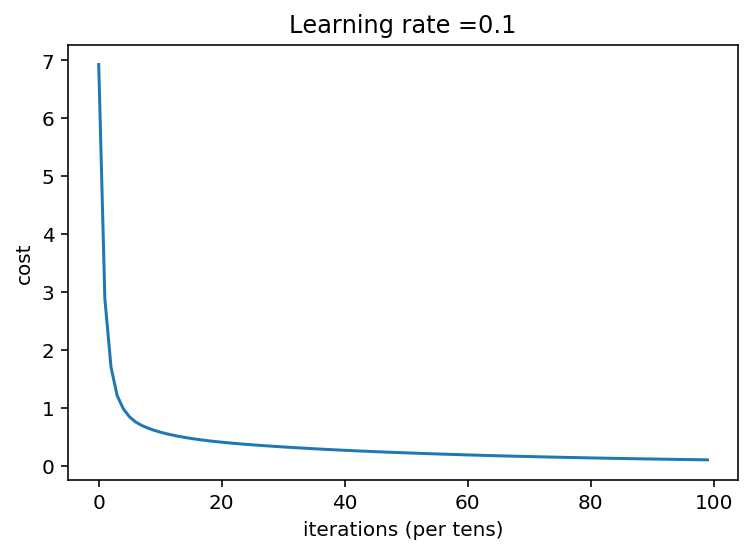

In [24]:
parameters = L_layer_model(X, Y, layers_dims, learning_rate=0.1, num_iterations = 10000, lambd = 0, print_cost = True)

In [25]:
AL, _ = L_model_forward(X, parameters)
y_pred = np.reshape(np.argmax(AL,axis=0),yprime.shape)
accuracy = np.mean(y_pred == yprime)*100
print("accuracy:{:3.2f}%".format(accuracy))

accuracy:99.46%


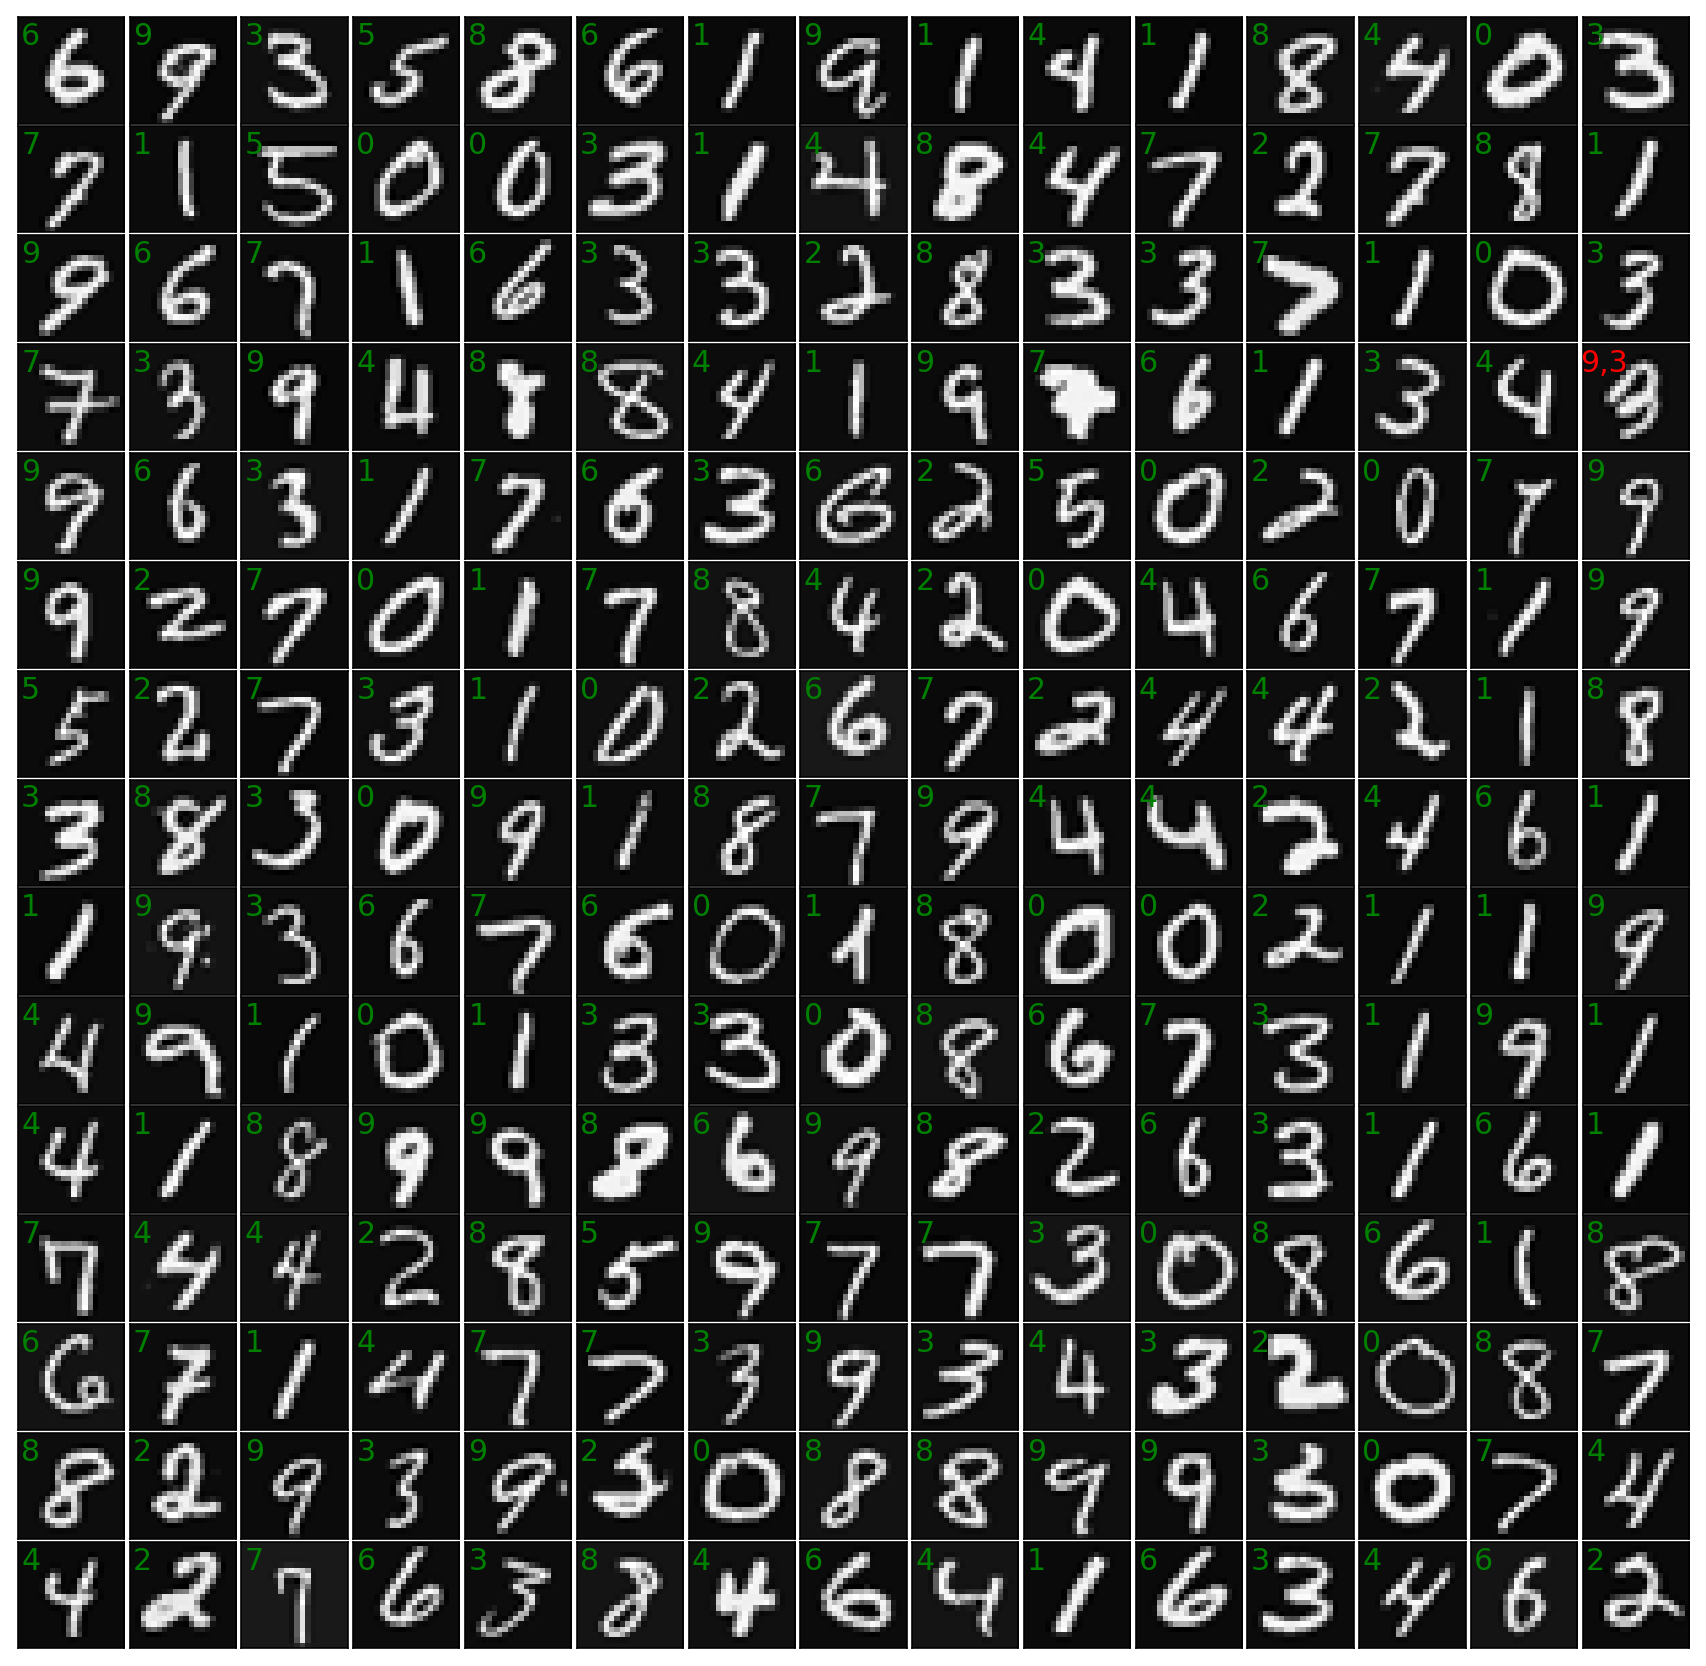

In [26]:
visualize(x,y_pred,yprime)

### Training with regularization

Cost after iteration 0: 6.938279
Cost after iteration 1000: 1.423079
Cost after iteration 2000: 1.389611
Cost after iteration 3000: 1.376727
Cost after iteration 4000: 1.368590
Cost after iteration 5000: 1.362079
Cost after iteration 6000: 1.357057
Cost after iteration 7000: 1.353829
Cost after iteration 8000: 1.351441
Cost after iteration 9000: 1.349684


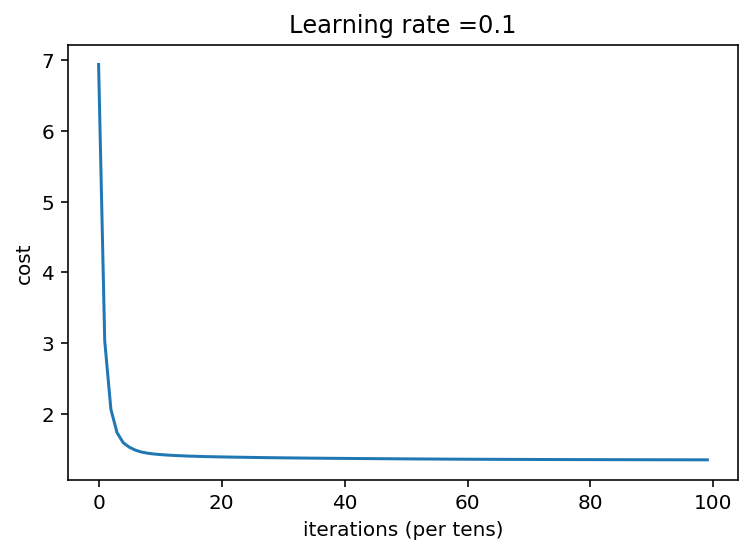

In [27]:
parameters_reg = L_layer_model(X, Y, layers_dims, learning_rate=0.1, num_iterations = 10000, lambd = 100, print_cost = True)

In [28]:
AL_reg, _ = L_model_forward(X, parameters_reg)
y_pred_reg = np.reshape(np.argmax(AL_reg,axis=0),yprime.shape)
accuracy_reg = np.mean(y_pred_reg == yprime)*100
print("accuracy_reg:{:3.2f}%".format(accuracy_reg))

accuracy_reg:92.00%


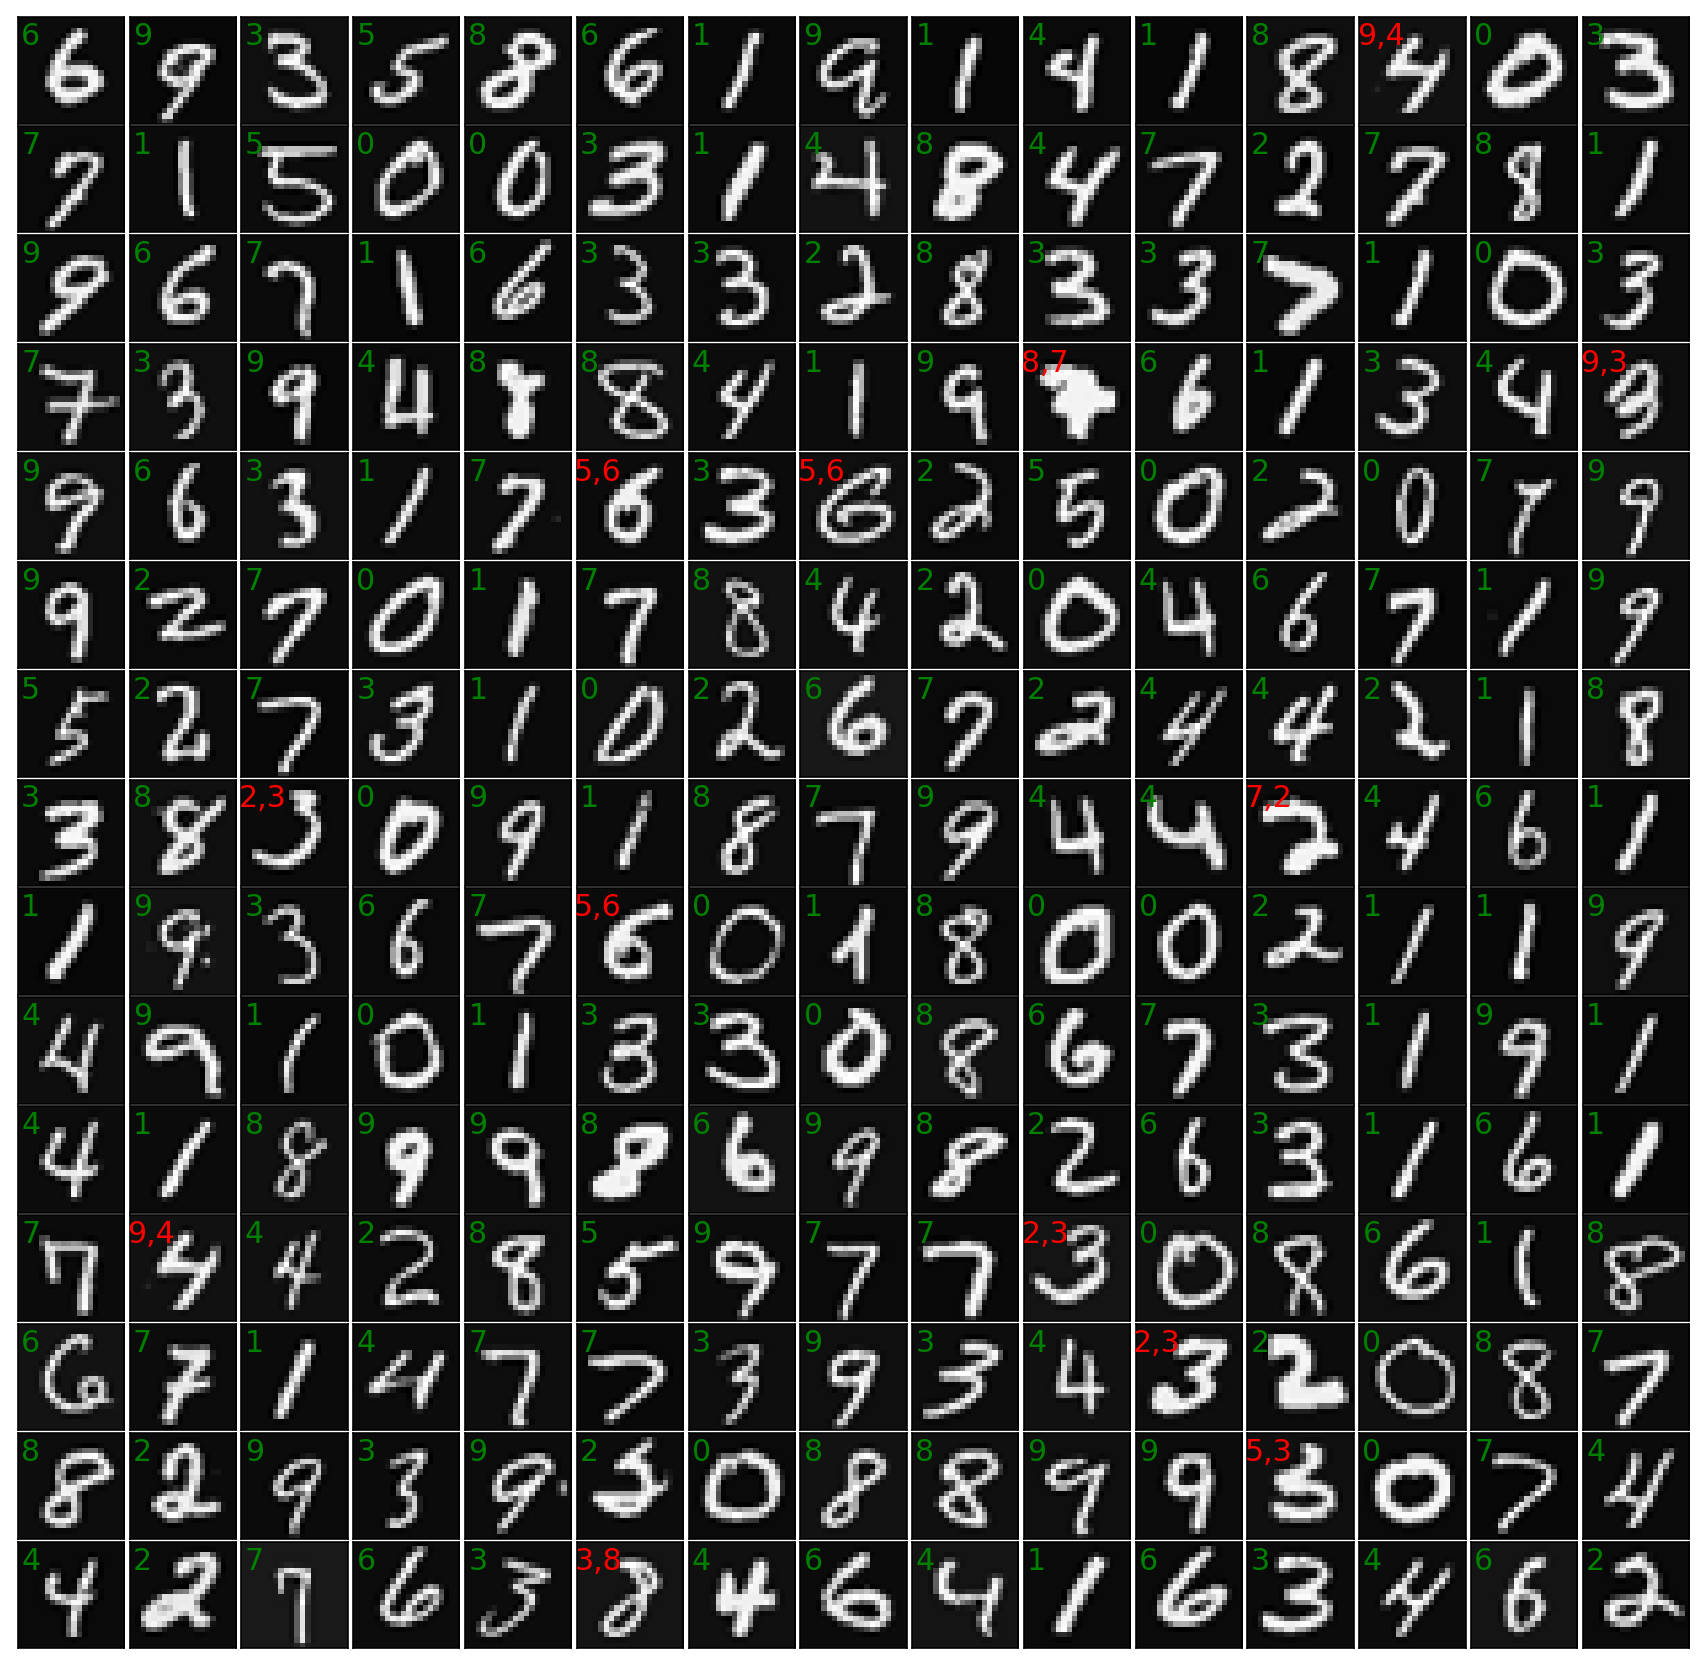

In [29]:
visualize(x,y_pred_reg,yprime)